<a href="https://colab.research.google.com/github/CharlTaylor/CharlTaylor/blob/main/FNCpres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import warnings
import itertools
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller

# Ignore the warning, can comment this
warnings.filterwarnings("ignore")

# For graphing purpose, can change
plt.style.use('seaborn-bright')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [ ]:
import pandas as pd
# Import the data
df = pd.read_csv("practise 15.csv")


In [ ]:
df

,Date,Listeners
0,2017-01-08,40
1,2017-01-15,37
2,2017-01-22,43
3,2017-01-29,46
4,2017-02-05,35
...,...,...
295,2022-09-04,50
296,2022-09-11,59
297,2022-09-18,53
298,2022-09-25,56


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
# Set the date as index
df = df.set_index('Date')
# Select the proper time period for weekly aggreagation
df = df['2017-01-02':'2022-10-09'].resample('W').sum()
df.head()

,Listeners
Date,
2017-01-08,40
2017-01-15,37
2017-01-22,43
2017-01-29,46
2017-02-05,35


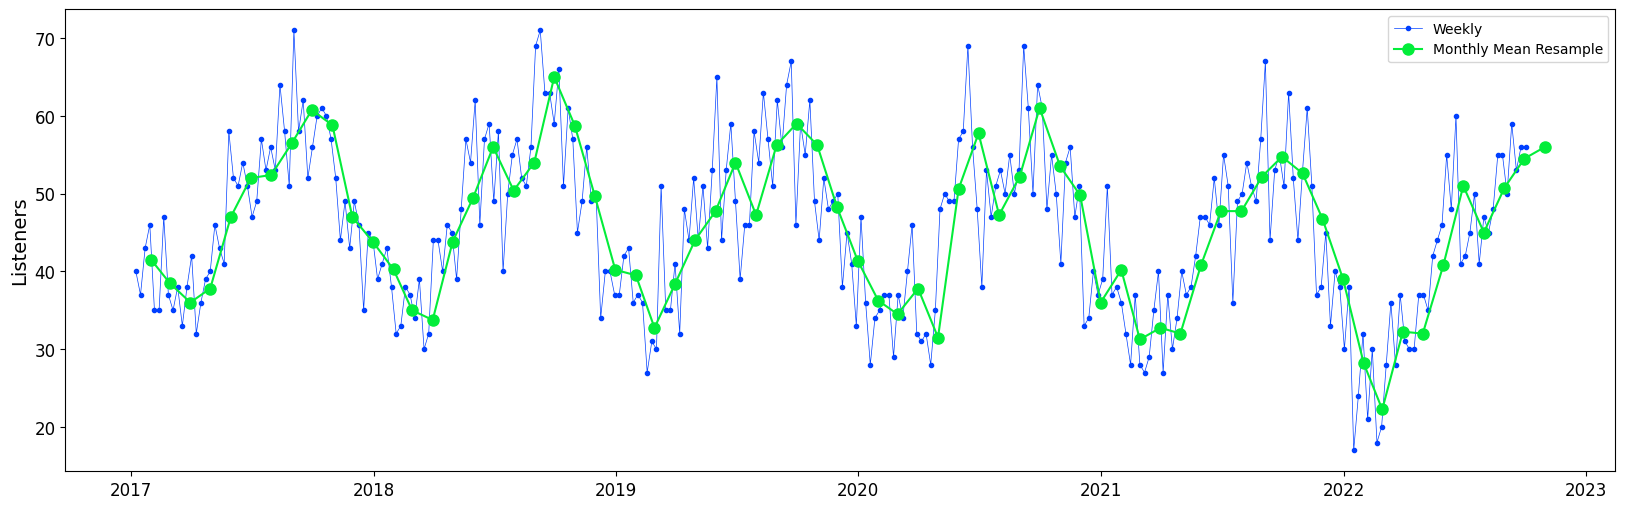

In [ ]:
import warnings
import matplotlib.pyplot as plt
y = df['Listeners']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Listeners')
ax.legend();

In [ ]:
import statsmodels.api as sm

# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

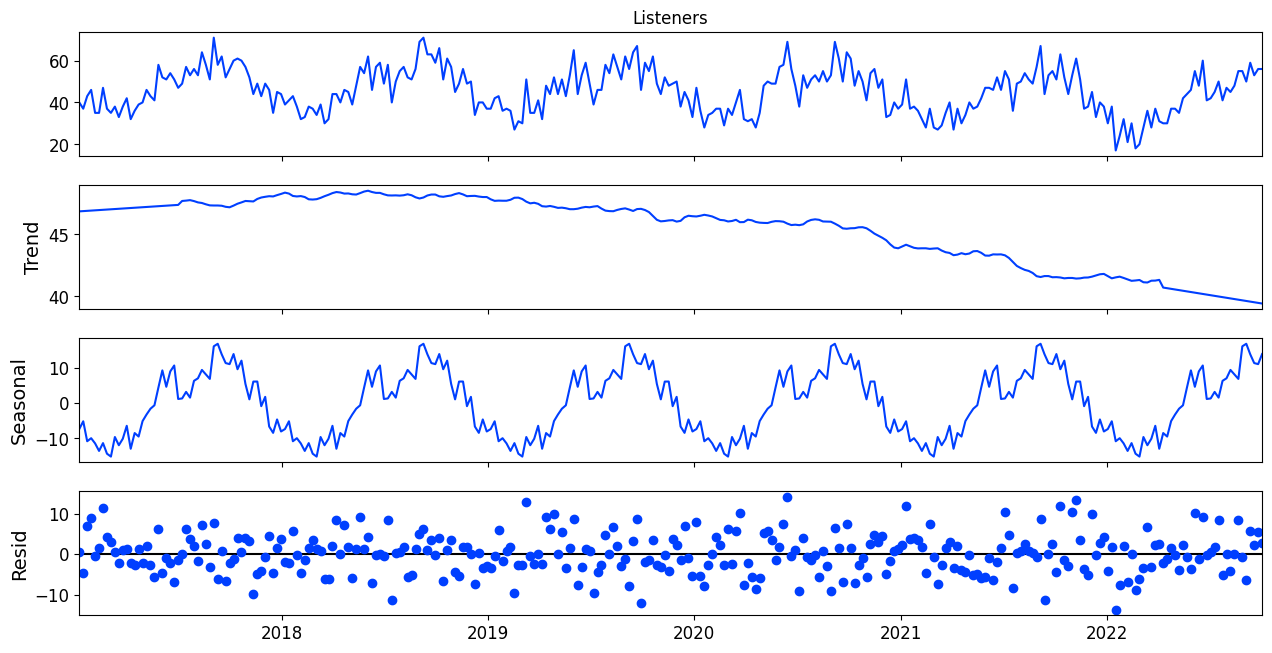

In [ ]:
seasonal_decompose(y)

In [ ]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):

    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()

    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

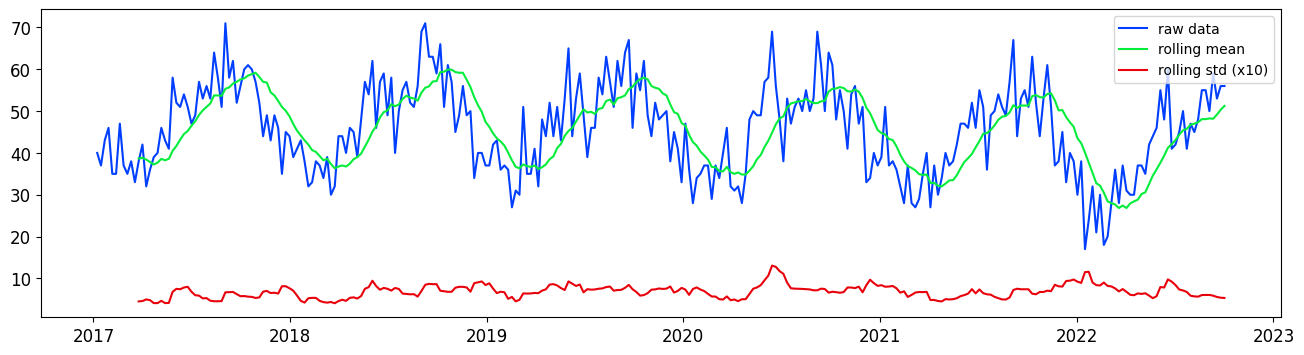

In [ ]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

In [ ]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [ ]:
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -5.348
P-value = 0.000
Critical values :
	1%: -3.453670163592738 - The data is  stationary with 99% confidence
	5%: -2.8718077069772248 - The data is  stationary with 95% confidence
	10%: -2.5722411158835796 - The data is  stationary with 90% confidence


 > Is the de-trended data stationary ?
Test statistic = -4.725
P-value = 0.000
Critical values :
	1%: -3.4534232986669546 - The data is  stationary with 99% confidence
	5%: -2.8716994185534745 - The data is  stationary with 95% confidence
	10%: -2.5721833625116144 - The data is  stationary with 90% confidence


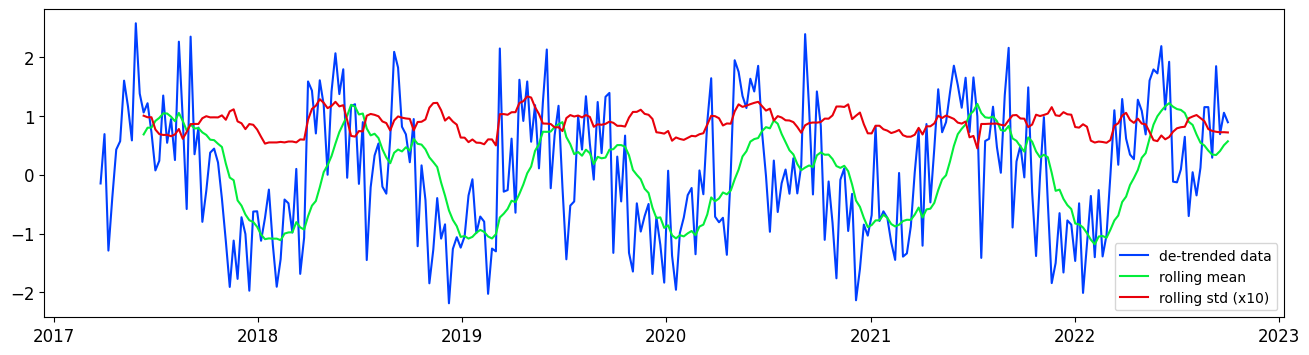

In [ ]:
# Detrending
y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

 > Is the 12 lag differenced data stationary ?
Test statistic = -4.680
P-value = 0.000
Critical values :
	1%: -3.454355055831705 - The data is  stationary with 99% confidence
	5%: -2.8721080938842976 - The data is  stationary with 95% confidence
	10%: -2.572401325619835 - The data is  stationary with 90% confidence


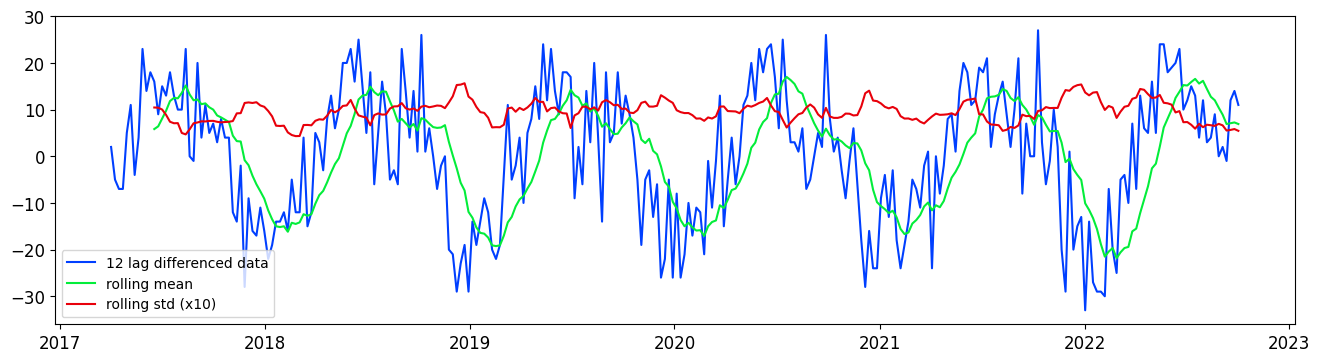

In [ ]:
# Differencing
y_12lag =  y - y.shift(12)

test_stationarity(y_12lag,'12 lag differenced data')
ADF_test(y_12lag,'12 lag differenced data')

 > Is the 12 lag differenced de-trended data stationary ?
Test statistic = -4.431
P-value = 0.000
Critical values :
	1%: -3.455365238788105 - The data is  stationary with 99% confidence
	5%: -2.8725510317187024 - The data is  stationary with 95% confidence
	10%: -2.5726375763314966 - The data is  stationary with 90% confidence


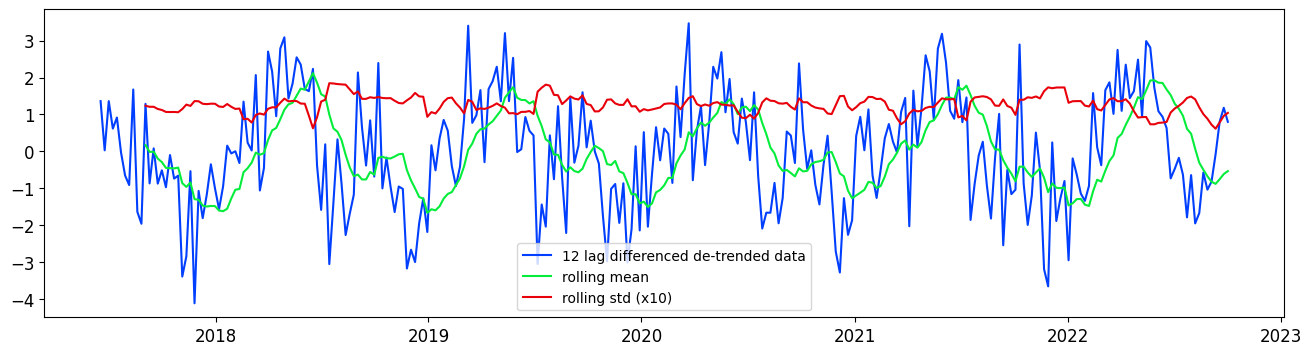

In [ ]:
# Detrending + Differencing

y_12lag_detrend =  y_detrend - y_detrend.shift(12)

test_stationarity(y_12lag_detrend,'12 lag differenced de-trended data')
ADF_test(y_12lag_detrend,'12 lag differenced de-trended data')

In [ ]:
y_to_train = y[:'2019-05-26'] # dataset to train
y_to_val = y['2019-06-02':] # last X months for test
predict_date = len(y) - len(y[:'2019-06-02']) # the number of data points for the test set

In [ ]:
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]

    mini = float('+inf')


    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()

                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [ ]:
sarima_grid_search(y,52)

The set of parameters with the minimum AIC is: SARIMA(1, 1, 1)x(0, 1, 1, 52) - AIC:1847.3013749017628


In [ ]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])

    results.plot_diagnostics(figsize=(16, 8))
    plt.show()

    # The dynamic=False argument ensures that we produce one-step ahead forecasts,
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()


    # In this case, I only use information from the time series up to a certain point,
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()

    return (results)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0255      0.076      0.336      0.737      -0.123       0.174
ma.L1         -0.9702      0.021    -45.419      0.000      -1.012      -0.928
ma.S.L52      -1.0001    340.284     -0.003      0.998    -667.944     665.943
sigma2        33.3741   1.14e+04      0.003      0.998   -2.22e+04    2.23e+04


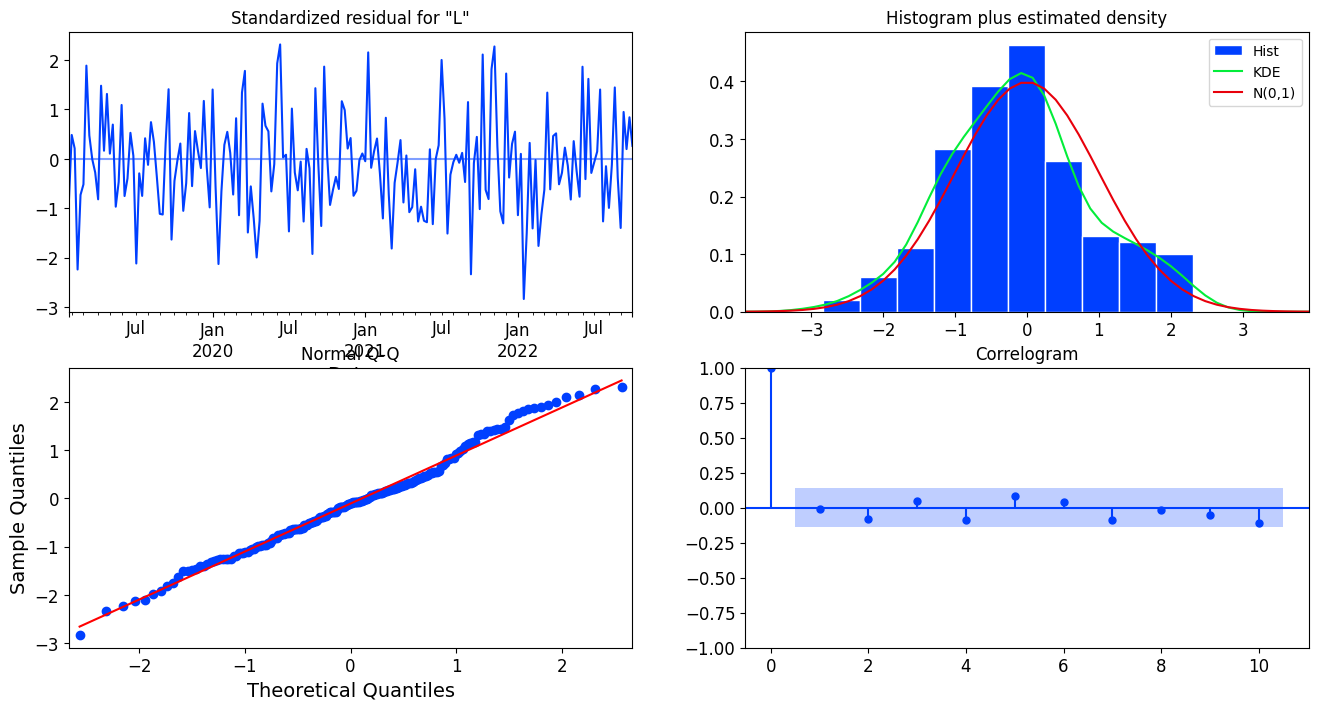

The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = False 6.61


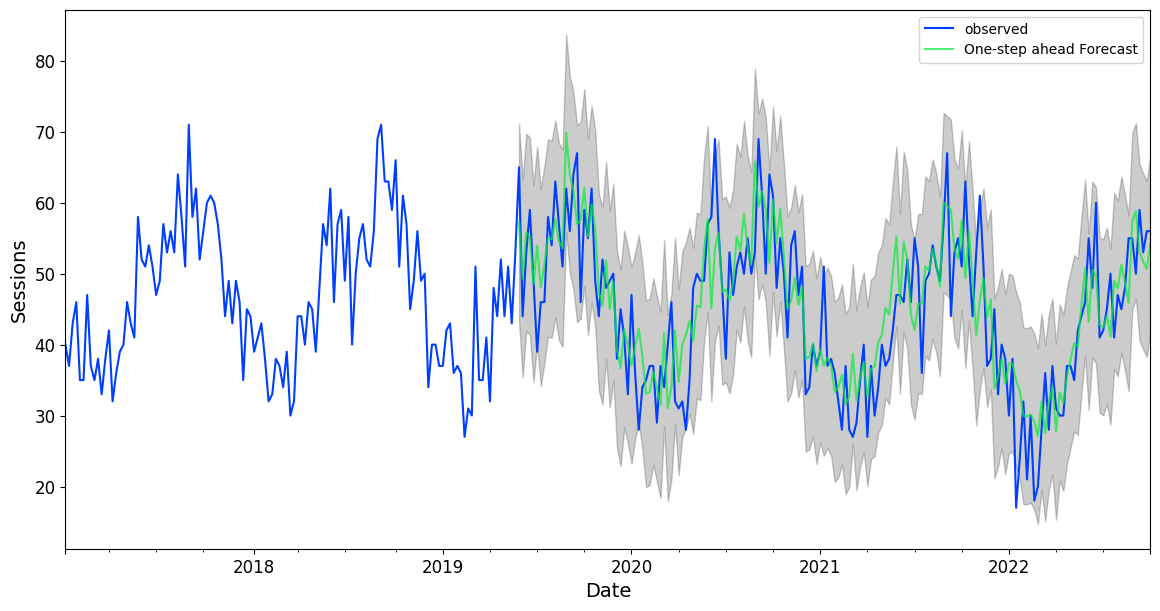

The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = True 8.44


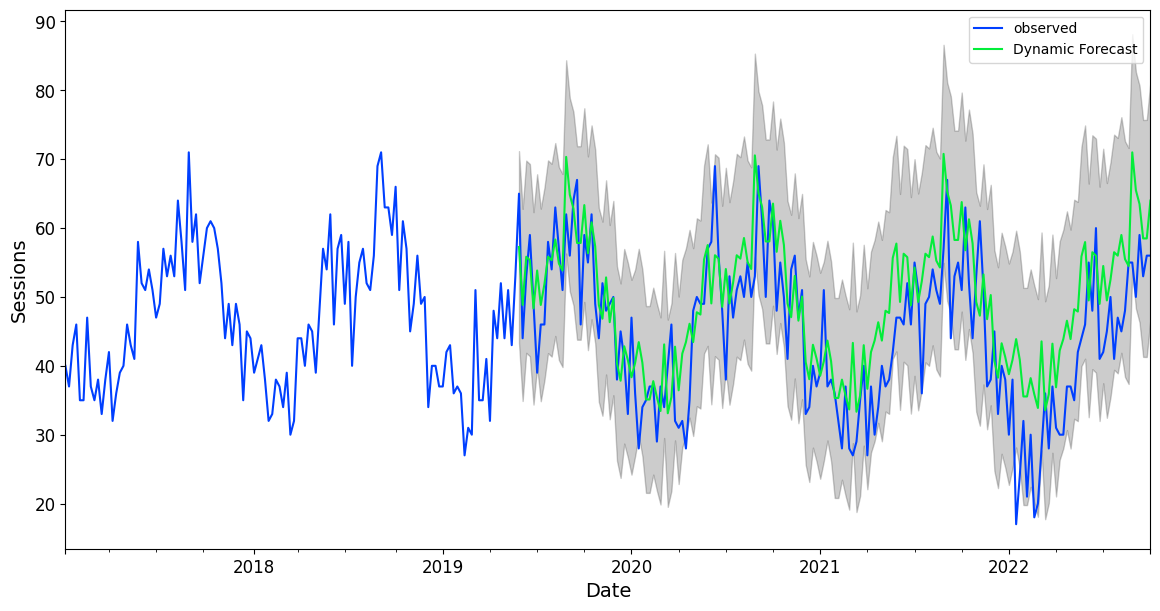

In [ ]:
model = sarima_eva(y,(1, 1, 1),(0, 1, 1, 52),52,'2019-06-02',y_to_val)

In [ ]:
def forecast(model,predict_steps,y):

    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()

    # Produce the forcasted tables
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')

    return (final_table)

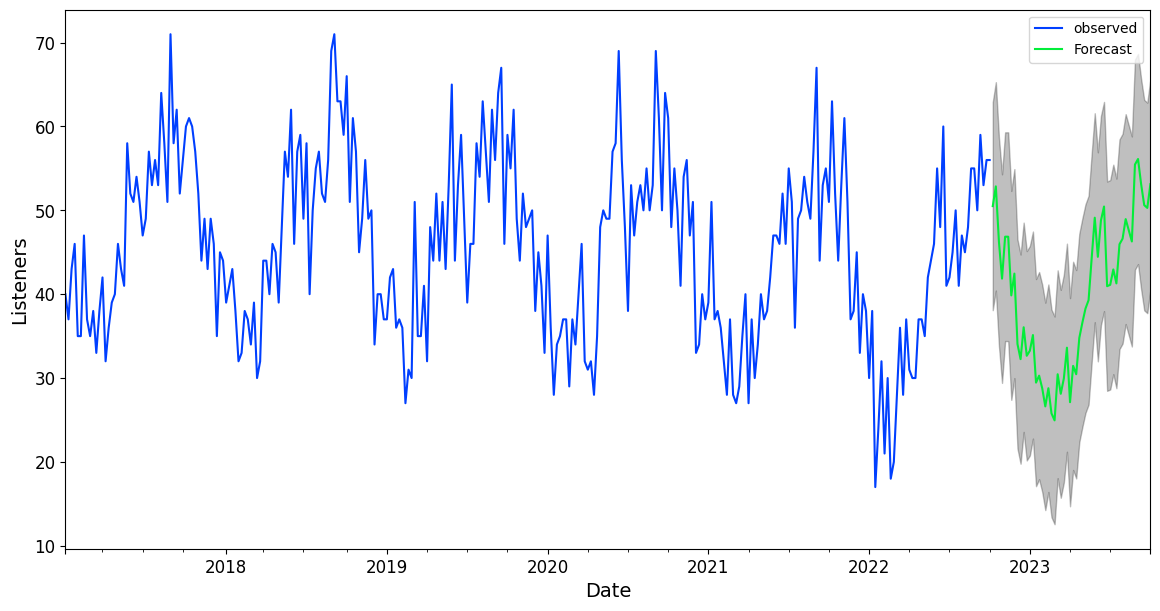

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2022-10-09,50.50108311,38.09446646,62.90769975
1,2022-10-16,52.85769224,40.43197725,65.28340724
2,2022-10-23,46.25662244,33.82486496,58.68837992
3,2022-10-30,41.85661767,29.41905903,54.29417630
4,2022-11-06,46.85657075,34.41321968,59.29992182


In [ ]:
final_table = forecast(model,52,y)
final_table.head()

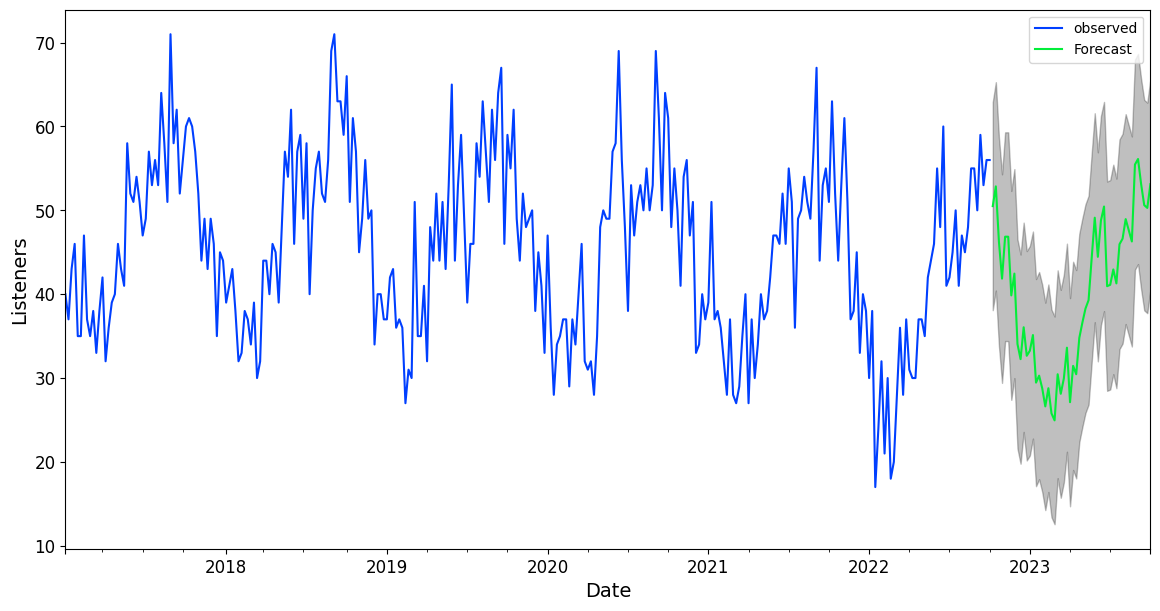

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2022-10-09,50.50108311,38.09446646,62.90769975
1,2022-10-16,52.85769224,40.43197725,65.28340724
2,2022-10-23,46.25662244,33.82486496,58.68837992
3,2022-10-30,41.85661767,29.41905903,54.29417630
4,2022-11-06,46.85657075,34.41321968,59.29992182


In [ ]:
final_table = forecast(model,52,y)
final_table.head()

In [1]:
!jupyter nbconvert --to PDF "Untitled.ipynb"

[NbConvertApp] WARNING | pattern 'Untitled.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Ex